In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    output = torch.tanh(self.input_layer(x))
    for layer in self.hidden_layers:
      output = layer(output)
    output = self.output_layer(output)
    return output

In [ ]:
## Defining the Steady state heat PDE
def heat_equation(T, x, a0, a1):
    T_x = torch.autograd.grad(T, x, torch.ones_like(T), create_graph=True)[0]
    alpha = a0 + a1*T
    T_xx = torch.autograd.grad(alpha*T_x, x, torch.ones_like(T), create_graph=True)[0]
    return T_xx

In [ ]:
## PDE training data
x1 = torch.linspace(0, 1, 100).view(-1, 1)
x1 = x1.view(-1)
x_train1 = x1.reshape(100, 1).requires_grad_(True)

In [ ]:
## Boundary condition training data
x3 = torch.tensor([[0. ,1.]]).view(-1, 1)
x3 = x3.view(-1)
x_train_boundary = x3.reshape(2, 1).requires_grad_(True)
T_train_boundary = torch.tensor([[0. ,10.]]).view(-1, 1)

In [ ]:
## Initialization of PINN
torch.manual_seed(69)
pinn = PINN(1,40,1,10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0001)

In [ ]:
## Training Loop
epochs = 100000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  T_pred = pinn(x_train1)
  pde_loss = heat_equation(T_pred, x_train1, 1, 0.1).pow(2).mean()

  T_pred_boundary = pinn(x_train_boundary)
  boundary_condition_loss = (T_pred_boundary - T_train_boundary).pow(2).mean()

  p1 = 1
  total_loss = pde_loss + p1*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 10000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")

Epoch 0/100000, Total Loss: 49.110023498535156, pde Loss: 5.587604618995101e-07, Boundary Loss: 49.110023498535156
Epoch 10000/100000, Total Loss: 0.1684781163930893, pde Loss: 0.11215721815824509, Boundary Loss: 0.05632089450955391
Epoch 20000/100000, Total Loss: 0.05285206437110901, pde Loss: 0.04349108785390854, Boundary Loss: 0.009360977448523045
Epoch 30000/100000, Total Loss: 0.0002712179848458618, pde Loss: 0.0002706752857193351, Boundary Loss: 5.426882125902921e-07
Epoch 40000/100000, Total Loss: 0.0018040554132312536, pde Loss: 0.0014990029158070683, Boundary Loss: 0.00030505252652801573
Epoch 50000/100000, Total Loss: 0.0011410238221287727, pde Loss: 0.0008555409149266779, Boundary Loss: 0.0002854829072020948
Epoch 60000/100000, Total Loss: 0.0022275950759649277, pde Loss: 0.002028296934440732, Boundary Loss: 0.00019929808331653476
Epoch 70000/100000, Total Loss: 2.2423124391934834e-05, pde Loss: 1.2775284631061368e-05, Boundary Loss: 9.647839760873467e-06
Epoch 80000/100000,

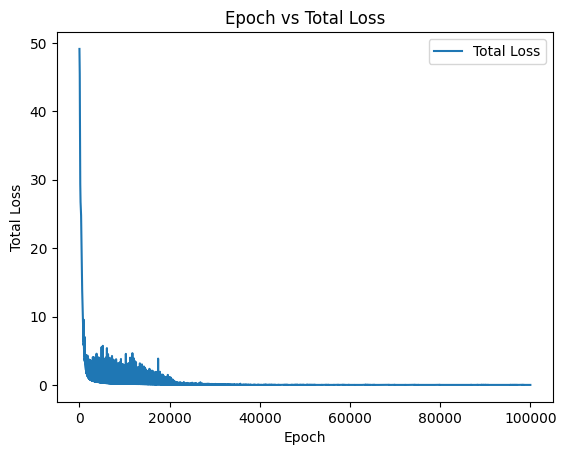

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

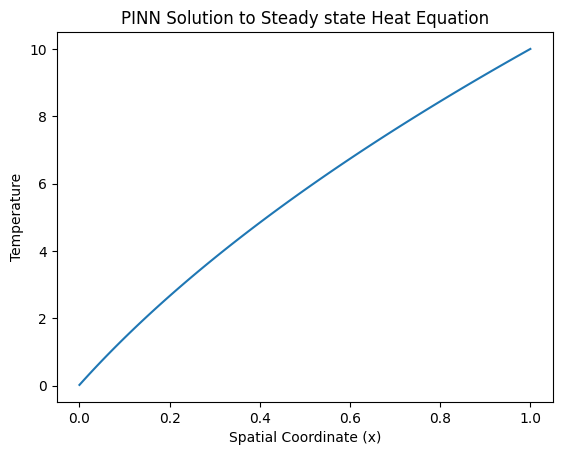

In [ ]:
## plot
with torch.no_grad():
    x_test = torch.linspace(0, 1, 100)
    x_test = x_test.reshape(-1, 1)
    T_test = pinn(x_test)
    x_test_ = x_test.detach().numpy()
    T_test_ = T_test.detach().numpy().reshape(x_test.shape)

fig = plt.figure()
plt.plot(x_test_, T_test_, label='Temperature variation with x')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Temperature')
plt.title('PINN Solution to Steady state Heat Equation')
plt.show()

In [ ]:
## Finding loss from expected value
# Test_loss = (T_test_ - 10*x_test_)
# Ind_loss = numpy.power(Test_loss, 2)
# print(Ind_loss.mean())

In [ ]:
## Adding Gaussian noise to the Temperature data
x_test = torch.linspace(0.1, 0.9, 11)
x_test = x_test.reshape(-1, 1)
T_test = pinn(x_test)
x_test_ = x_test.detach().numpy()
T_test_ = T_test.detach().numpy().reshape(x_test.shape)
mean = 0
std_dev = 0.1
gaussian_noise = numpy.random.normal(mean, std_dev, T_test_.shape)
T_noise_ = T_test_ + gaussian_noise
T_noise = torch.tensor(T_noise_)

In [ ]:
## Actual training data for Inverse PINN
x = x_test.requires_grad_(True)
T_train_actual = T_noise.requires_grad_(True)

In [ ]:
## PDE training data
x1 = torch.linspace(0, 1, 100).view(-1, 1)
x1 = x1.view(-1)
x_train1 = x1.reshape(100, 1).requires_grad_(True)

In [ ]:
## Boundary condition training data
Temp1val = 15.
Temp2val = 30.
Temperature1 = torch.tensor([Temp1val], requires_grad=True)
Temperature2 = torch.tensor([Temp2val], requires_grad=True)
x3_1 = torch.tensor([0.]).view(-1, 1)
x3_2 = torch.tensor([1.]).view(-1, 1)
x_train_boundary1 = x3_1.requires_grad_(True)
x_train_boundary2 = x3_2.requires_grad_(True)

In [ ]:
## Initialization of PINN
# alpha0val = 2.
# alpha1val = 0.01
# alpha0 = torch.tensor([alpha0val], requires_grad=True)
# alpha1 = torch.tensor([alpha1val], requires_grad=True)
torch.manual_seed(68)
pinn2 = PINN(1,40,1,10)
parameters = [
    {'params': pinn2.parameters(), 'lr': 0.0001},
    {'params': [Temperature2], 'lr': 0.05},
    {'params': [Temperature1], 'lr': 0.05}
    # {'params': [alpha1], 'lr': 0.025}
]
optimizer = torch.optim.Adam(parameters)

In [ ]:
## Training Loop
epochs = 100000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  T_pred_actual = pinn2(x)
  Actual_loss = (T_pred_actual - T_train_actual).pow(2).mean()

  T_pred = pinn2(x_train1)
  pde_loss = heat_equation(T_pred, x_train1, 1, 0.1).pow(2).mean()

  T_train_boundary1 = Temperature1
  T_train_boundary2 = Temperature2
  T_pred_boundary1 = pinn2(x_train_boundary1)
  T_pred_boundary2 = pinn2(x_train_boundary2)
  boundary_condition_loss = (T_pred_boundary1 - T_train_boundary1).pow(2).mean() + (T_pred_boundary2 - T_train_boundary2).pow(2).mean()

  p1 = 1
  p2 = 1
  total_loss = Actual_loss + p1*pde_loss + p2*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 5000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Temperature1: {Temperature1.item()}, Temperature2: {Temperature2.item()}")

Epoch 0/100000, Total Loss: 1166.4086767618217, pde Loss: 8.901159276319959e-08, Boundary Loss: 1127.976806640625, Temperature1: 14.949999809265137, Temperature2: 29.950000762939453
Epoch 5000/100000, Total Loss: 6.088143569678366, pde Loss: 2.0513898562057875e-06, Boundary Loss: 6.02540239924565e-11, Temperature1: 5.6537041664123535, Temperature2: 5.654091835021973
Epoch 10000/100000, Total Loss: 0.48323776086145587, pde Loss: 0.2858947217464447, Boundary Loss: 0.030114399269223213, Temperature1: 1.1688947677612305, Temperature2: 9.397343635559082
Epoch 15000/100000, Total Loss: 0.08065954182274104, pde Loss: 0.025890551507472992, Boundary Loss: 1.1953912917306297e-06, Temperature1: 0.6018257141113281, Temperature2: 9.734259605407715
Epoch 20000/100000, Total Loss: 0.043019146851023204, pde Loss: 0.014904103241860867, Boundary Loss: 1.6407697955855838e-07, Temperature1: 0.39114007353782654, Temperature2: 9.85417366027832
Epoch 25000/100000, Total Loss: 0.03274891682616489, pde Loss: 0

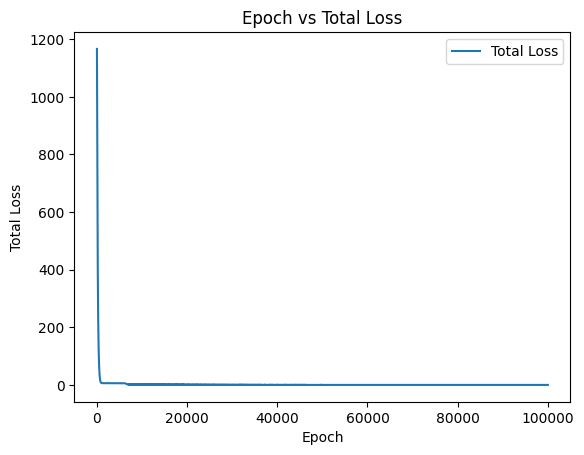

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()